In [1]:
# numpy handles pretty much anything that is a number/vector/matrix/array
import numpy as np
# pandas handles dataframes
import pandas as pd
# matplotlib emulates Matlabs plotting functionality
import matplotlib.pyplot as plt
# stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow INFO and WARNING messages
# self explainatory, dates and times
from datetime import datetime, date
# a helper package to help us iterate over objects
import itertools

import IPython.display as ipd
import librosa
import librosa.display
from tqdm import tqdm

import matplotlib.pylab as pltimport 
import seaborn as sns
import keras
import tensorflow as tf
from glob import glob
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten, Conv2D, MaxPooling2D, Flatten, BatchNormalization,  Input
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report
import librosa
import librosa.display
import IPython.display as ipd
import time
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pyarrow.parquet as pq
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow.keras.backend as K
import random
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
#from itertools import cycle

/home/tooloo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-05-30 02:58:07.027436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 02:58:08.061352: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_triplet_data(mfccs, accents, batch_size):
    num_samples, feature_dim = np.shape(mfccs)
    
    triplet_a = np.zeros((batch_size, feature_dim))
    triplet_b = np.zeros((batch_size, feature_dim))
    triplet_c = np.zeros((batch_size, feature_dim))
    
    for i in range(batch_size):
        idx1 = random.randint(0, num_samples - 1)
        idx2 = random.randint(0, num_samples - 1)
        idx3 = random.randint(0, num_samples - 1)

        while accents[idx1] != accents[idx2]:
            idx2 = random.randint(0, num_samples - 1)            
                
        while accents[idx1] == accents[idx3]:
            idx3 = random.randint(0, num_samples - 1)

        triplet_a[i, :] = mfccs[idx1]
        triplet_b[i, :] = mfccs[idx2]
        triplet_c[i, :] = mfccs[idx3]

        ''' Print the triplets made for debugging
        print(f"Triplet {i}: idx1={idx1}, idx2={idx2}, idx3={idx3}")
        print(f"Accent1={accents[idx1]}, Accent2={accents[idx2]}, Accent3={accents[idx3]}")
        print("Triplet A MFCC:", triplet_a[i, :])
        print("Triplet B MFCC:", triplet_b[i, :])
        print("Triplet C MFCC:", triplet_c[i, :])
        '''
    return [triplet_a, triplet_b, triplet_c]

In [3]:
# Specify the path to your Parquet file
parquet_file = 'Validated_Mean_MFCCs.parquet'

# Open the Parquet file
parquet_fp = pq.ParquetFile(parquet_file)

# Read the entire Parquet file into a pandas DataFrame
df = parquet_fp.read().to_pandas()

# Extract class labels
class_labels = df['accent'].unique().tolist()

# Ensure mfcc is converted to a numeric type
df['mfcc'] = df['mfcc'].apply(lambda x: np.array(x, dtype=np.float32))

# Ensure accent is also numeric or at least categorical
df['accent'] = pd.Categorical(df['accent']).codes

print(len(df))


24391


In [4]:
df['accent'].unique()

array([11,  0, 15,  4,  7,  9,  2, 16,  6,  3,  1, 10,  8, 12,  5, 13, 14],
      dtype=int8)

In [5]:
X = np.array(df['mfcc'].tolist())
y = np.array(df['accent'].tolist())

In [6]:
print(f"MFCCs shape: {X.shape}")
print(f"Accents shape: {y.shape}")

MFCCs shape: (24391, 50)
Accents shape: (24391,)


In [7]:
# Create triplets
batch_size = 128
triplets = get_triplet_data(X, y, batch_size)

In [8]:
# First split: split the original dataset into a training set and a temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Second split: split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


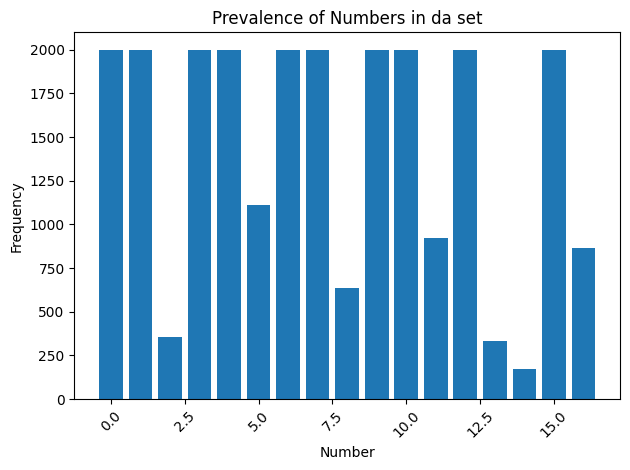

In [9]:
numbers_array = y  # Example array creation

# Count the occurrences of each number
counter_data = Counter(numbers_array)

# Plot the data
plt.bar(counter_data.keys(), counter_data.values())
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Prevalence of Numbers in da set')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [10]:

def create_base_network(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)  # L2 normalization
    return models.Model(inputs, outputs)

def create_siamese_network(input_shape):
    base_network = create_base_network(input_shape)
    
    input_a = tf.keras.Input(shape=input_shape)
    input_b = tf.keras.Input(shape=input_shape)
    input_c = tf.keras.Input(shape=input_shape)
    
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    processed_c = base_network(input_c)
    
    merged_output = layers.Concatenate(axis=1)([processed_a, processed_b, processed_c])
    
    return models.Model([input_a, input_b, input_c], merged_output)

def triplet_loss(margin=0.5):
    def _triplet_loss(y_true, y_pred):
        anchor, positive, negative = tf.split(y_pred, num_or_size_splits=3, axis=1)
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
        return tf.reduce_mean(loss)
    return _triplet_loss

input_shape = (X.shape[1],)

siamese_network = create_siamese_network(input_shape)
siamese_network.compile(optimizer='adam', loss=triplet_loss(margin=1.0))

# Example training loop
batch_size = 64
epochs = 100

dummy_y = np.zeros((batch_size, 3))  # Create dummy labels

for epoch in range(epochs):
    triplets = get_triplet_data(X, y, batch_size)
    siamese_network.train_on_batch(triplets, dummy_y)

# Freeze the base network layers
base_network = siamese_network.layers[3]
base_network.trainable = True

# Create the classification model
classification_input = tf.keras.Input(shape=input_shape)
embedding = base_network(classification_input)
classification_output = layers.Dense(17, activation='softmax')(embedding)

classification_model = models.Model(classification_input, classification_output)
classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Save the model
checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification_Triplet_Model.keras', verbose=1 , save_best_only=True)

# Record training time
start = datetime.now()

# Train the classifier
training = classification_model.fit(X_train, 
                                    y_train, 
                                    epochs=epochs, 
                                    batch_size=batch_size,
                                    shuffle=True,
                                    validation_data=(X_val,y_val), callbacks=[checkpointer])
duration = datetime.now() - start
print("training completed in time: ", duration)

2024-05-30 02:58:09.321668: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 02:58:09.322114: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/100
260/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2144 - loss: 2.6663
Epoch 1: val_loss improved from inf to 2.34117, saving model to saved_models/audio_classification_Triplet_Model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2165 - loss: 2.6622 - val_accuracy: 0.3444 - val_loss: 2.3412
Epoch 2/100
243/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3940 - loss: 2.2222
Epoch 2: val_loss improved from 2.34117 to 2.05606, saving model to saved_models/audio_classification_Triplet_Model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3950 - loss: 2.2163 - val_accuracy: 0.4239 - val_loss: 2.0561
Epoch 3/100
242/267 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4477 - loss: 1.9604
Epoch 3: val_loss improved from 2.05606 to 1.95062, saving model to saved_models/audio_classification_Triplet_Model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4482 - loss: 1.9571 - val_accuracy: 0.4326 - val_loss: 1.9506
Epoch 4/100
249/267 ━━━━━━

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                precision    recall  f1-score   support

   philippines       0.74      0.79      0.76       299
       african       0.74      0.83      0.78       272
            us       0.85      0.71      0.77        55
       england       0.67      0.81      0.73       306
       ireland       0.80      0.57      0.67       292
    newzealand       0.89      0.93      0.91       156
       bermuda       0.82      0.75      0.79       300
         wales       0.85      0.85      0.85       298
        indian       0.80      0.81      0.80        88
        canada       0.84      0.85      0.84       311
     australia       0.75      0.74      0.74       283
         other       0.71      0.79      0.75       152
      malaysia       0.82      0.78      0.80       308
      scotland       0.69      0.69      0.69        52
      hongkong       0.76      0.57      0.65        23
     singapore       0.57      0.59      0.58       345
southa

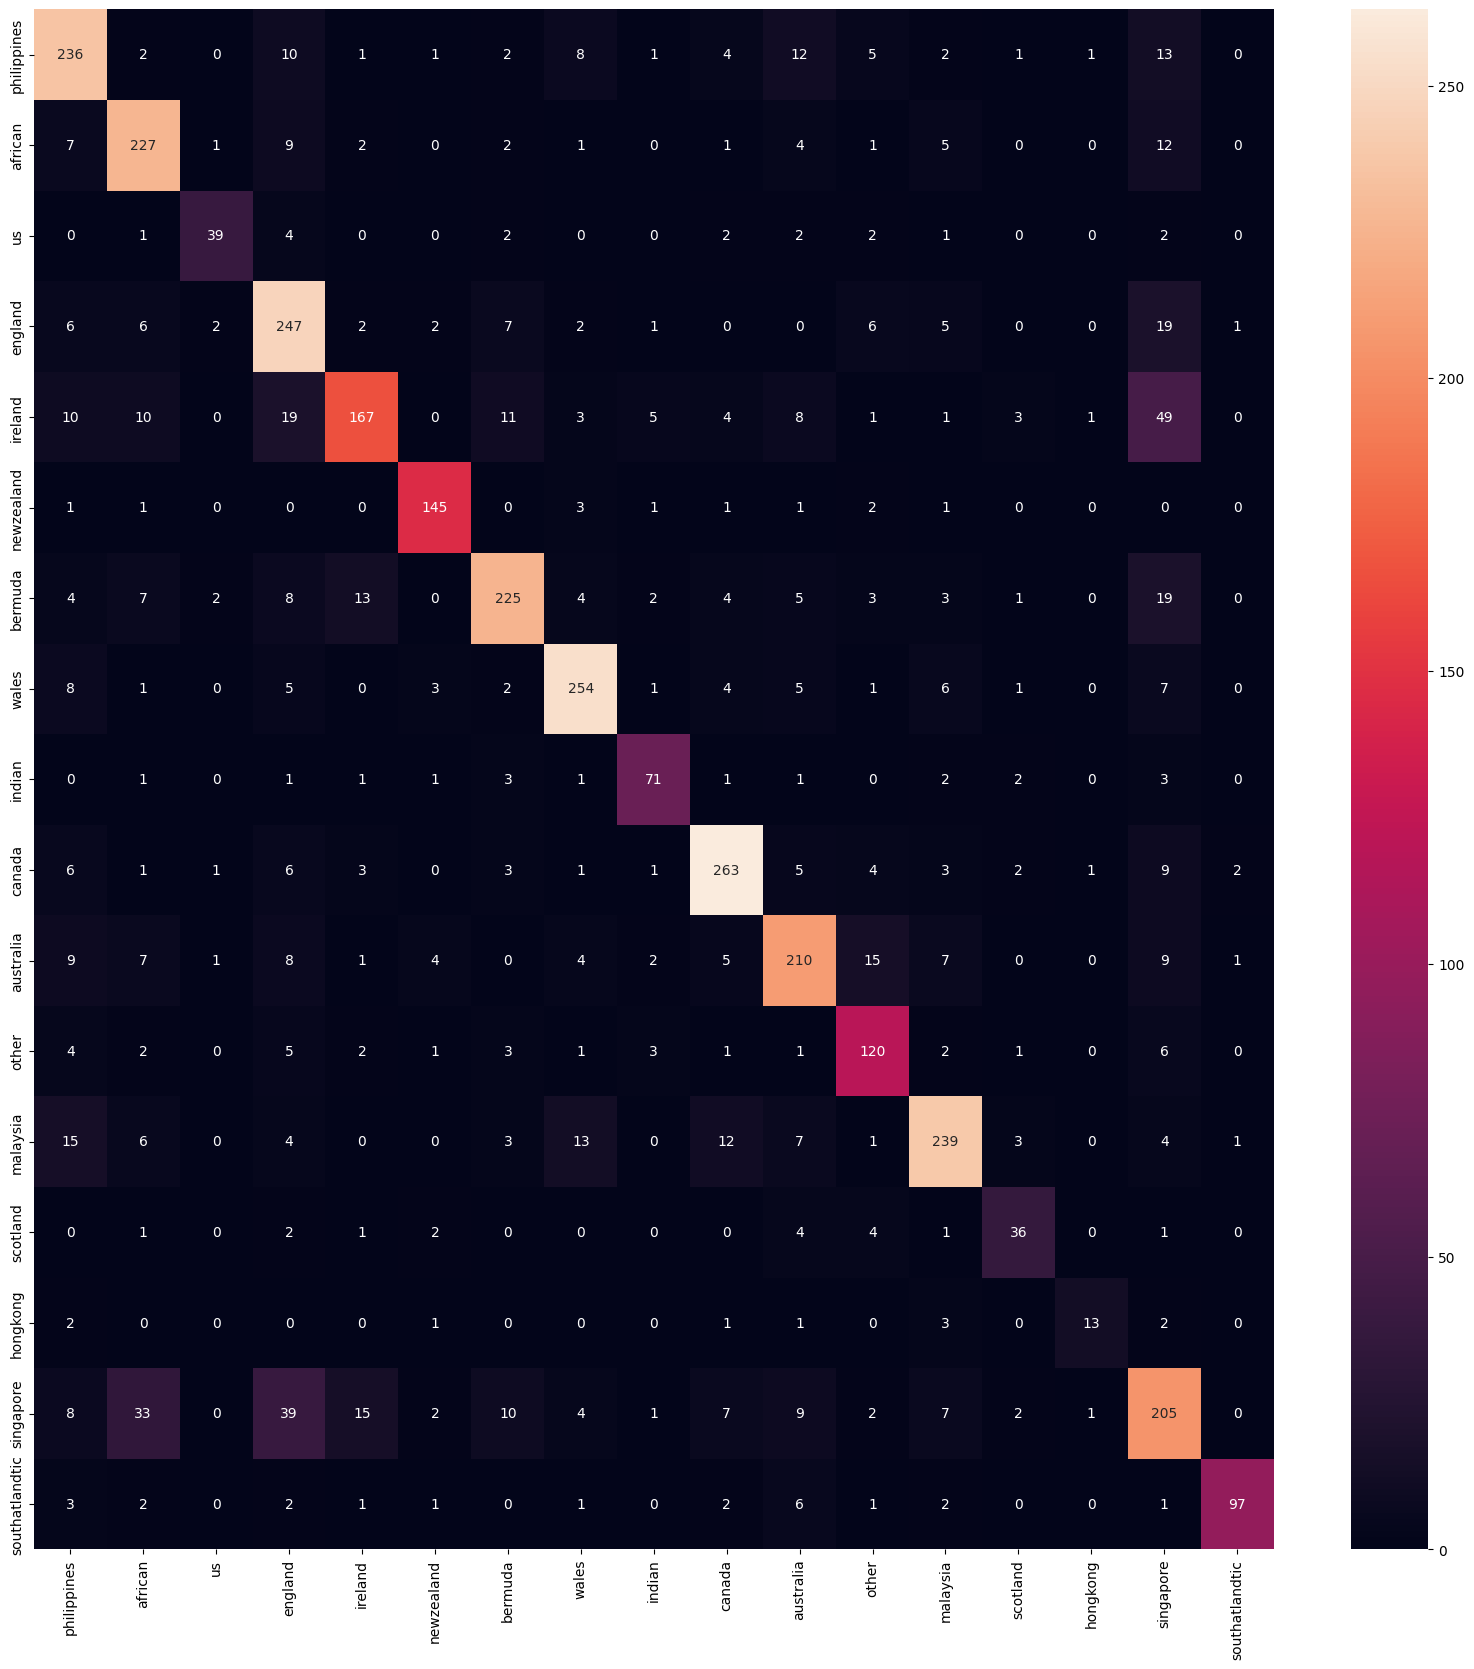

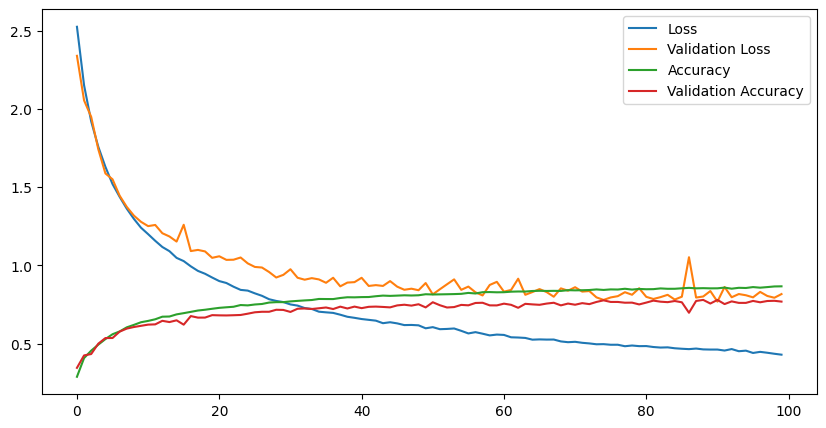

In [11]:
def eval_model(model, history, x_train, y_train, x_test, y_test, class_labels):
    fig = plt.figure(figsize=[20, 20])

    ax = fig.add_subplot(1, 1, 1)
    pred = model.predict(x_test)
    indexes = np.argmax(pred, axis=1)
    gt_idx = y_test  # y_test is already in the correct form

    # Calculate confusion matrix for all labels
    confusion_mtx = confusion_matrix(gt_idx, indexes)
    sns.heatmap(confusion_mtx, annot=True, fmt='g', ax=ax, xticklabels=class_labels, yticklabels=class_labels)

    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history.history['loss'], label='Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.plot(history.history['accuracy'], label='Accuracy')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.legend()

    print(classification_report(gt_idx, indexes, target_names=class_labels))

    # Calculate and print average precision, recall, and F1-score
    precision = precision_score(gt_idx, indexes, average='weighted')
    recall = recall_score(gt_idx, indexes, average='weighted')
    f1 = f1_score(gt_idx, indexes, average='weighted')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

# Evaluate the model
eval_model(classification_model, training, X_train, y_train, X_test, y_test, class_labels)

In [12]:
train_hist = pd.DataFrame(training.history)
train_hist

,accuracy,loss,val_accuracy,val_loss
0,0.287179,2.527020,0.344356,2.341168
1,0.406783,2.152755,0.423886,2.056062
2,0.454285,1.921784,0.432632,1.950624
3,0.492825,1.759121,0.499043,1.743259
4,0.528378,1.630549,0.534846,1.588452
...,...,...,...,...
95,0.861184,0.439607,0.772615,0.795510
96,0.857377,0.446593,0.763870,0.830411
97,0.861126,0.441018,0.772069,0.804399
98,0.865226,0.434460,0.773435,0.792998


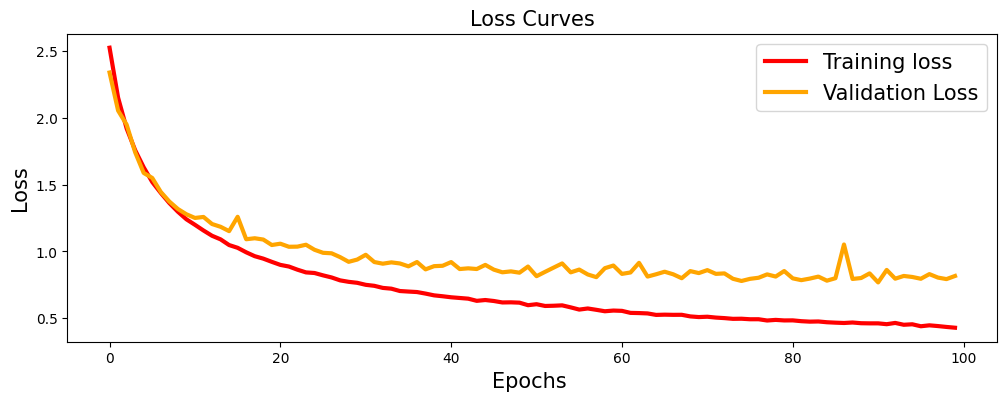

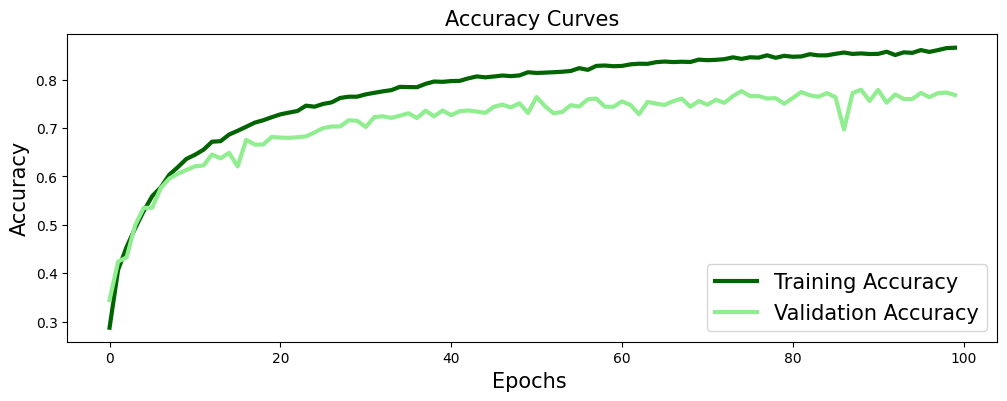

In [13]:
# Loss curves
plt.figure(figsize=[12,4])
plt.plot(training.history['loss'],'red',linewidth=3.0)
plt.plot(training.history['val_loss'],'orange',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=15)
plt.xlabel('Epochs ',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title('Loss Curves',fontsize=15)


# Accuracy Curves
plt.figure(figsize=[12,4])
plt.plot(training.history['accuracy'],'darkgreen',linewidth=3.0)
plt.plot(training.history['val_accuracy'],'lightgreen',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=15)
plt.xlabel('Epochs ',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title('Accuracy Curves',fontsize=15)
plt.show()